In [2]:
# Import core libraries for data handling and modeling
import pandas as pd
import numpy as np

# Import train-test split and models from scikit-learn and XGBoost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

# Import evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Import LIME for model interpretability
import lime
from lime.lime_tabular import LimeTabularExplainer

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_task3_MachineLearningRating.csv')



C:\Users\metya\AppData\Local\Temp\ipykernel_15716\2936573832.py:6: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/cleaned_task3_MachineLearningRating.csv')


In [4]:
# Strip whitespace from all object columns and replace empty strings with NaN
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()  # remove leading/trailing spaces
    df[col].replace('', np.nan, inplace=True)  # replace empty strings with NaN

C:\Users\metya\AppData\Local\Temp\ipykernel_15716\3404945913.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('', np.nan, inplace=True)  # replace empty strings with NaN


In [5]:
# Convert datetime columns to datetime dtype and extract numeric features
datetime_cols = ['VehicleIntroDate', 'TransactionMonth']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)

C:\Users\metya\AppData\Local\Temp\ipykernel_15716\1955848187.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [6]:
# Fill missing numeric values with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with 'Unknown'
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')

# Clean 'make' column if exists
if 'make' in df.columns:
    df['make'] = df['make'].str.strip()

In [7]:
# Identify all categorical columns (object dtype)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# one-hot encode all categorical columns (including those with 'Unknown')
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [8]:
# Prepare data for Claim Severity (regression)
df_claims = df[df['TotalClaims'] > 0].copy()
X_severity = df_claims.drop(columns=['TotalClaims', 'CalculatedPremiumPerTerm', 'ClaimFrequency'], errors='ignore')
y_severity = df_claims['TotalClaims']

In [9]:
# Prepare data for Claim Probability (classification)
X_prob = df.drop(columns=['TotalClaims', 'CalculatedPremiumPerTerm'], errors='ignore')
y_prob = df['ClaimFrequency']

In [10]:
# Train-test split
X_sev_train, X_sev_test, y_sev_train, y_sev_test = train_test_split(
    X_severity, y_severity, test_size=0.2, random_state=42)

X_prob_train, X_prob_test, y_prob_train, y_prob_test = train_test_split(
    X_prob, y_prob, test_size=0.2, random_state=42)

print(f"Claim Severity: X_train={X_sev_train.shape}, X_test={X_sev_test.shape}")
print(f"Claim Probability: X_train={X_prob_train.shape}, X_test={X_prob_test.shape}")

Claim Severity: X_train=(2230, 1044), X_test=(558, 1044)
Claim Probability: X_train=(799844, 1045), X_test=(199961, 1045)


In [ ]:
from sklearn.utils import resample

# Sample 10,000 rows (adjust size based on your RAM)
X_prob_sample, y_prob_sample = resample(X_prob_train, y_prob_train, n_samples=10000, random_state=42)

# Train on smaller sample
lr_prob = LogisticRegression(max_iter=1000)
lr_prob.fit(X_prob_sample, y_prob_sample)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# Convert boolean columns to int
bool_cols = X_prob_train.select_dtypes(include=['bool']).columns
X_prob_train[bool_cols] = X_prob_train[bool_cols].astype(int)
X_prob_test[bool_cols] = X_prob_test[bool_cols].astype(int)

# Verify all columns are numeric
assert all([np.issubdtype(dtype, np.number) for dtype in X_prob_train.dtypes]), "Non-numeric columns remain"


In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000)
batch_size = 10000

classes = np.unique(y_prob_train)

for start in range(0, X_prob_train.shape[0], batch_size):
    end = start + batch_size
    X_batch = X_prob_train.iloc[start:end]
    y_batch = y_prob_train.iloc[start:end]
    sgd_clf.partial_fit(X_batch, y_batch, classes=classes)


In [15]:
from sklearn.utils import resample

X_prob_sample, y_prob_sample = resample(X_prob_train, y_prob_train, n_samples=10000, random_state=42)

lr_prob = LogisticRegression(max_iter=1000, solver='saga')
lr_prob.fit(X_prob_sample, y_prob_sample)


c:\Users\metya\anaconda3\envs\insurance-risk-analytics\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Claim Severity Models (Regression)
print(f"Training Severity models (shape: {X_sev_train.shape})...")
lr_sev = LinearRegression().fit(X_sev_train, y_sev_train)
rf_sev = RandomForestRegressor(random_state=42).fit(X_sev_train, y_sev_train)
xgb_sev = XGBRegressor(random_state=42).fit(X_sev_train, y_sev_train)
print("Severity models trained.")


Training Severity models (shape: (2230, 1044))...
Severity models trained.


### Model Evaluation
### Calculating performance metrics for all models on their respective test sets.

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_sev_pred_lr = lr_sev.predict(X_sev_test)
y_sev_pred_rf = rf_sev.predict(X_sev_test)
y_sev_pred_xgb = xgb_sev.predict(X_sev_test)

# Evaluate Linear Regression
rmse_lr_sev = np.sqrt(mean_squared_error(y_sev_test, y_sev_pred_lr))
r2_lr_sev = r2_score(y_sev_test, y_sev_pred_lr)
print(f"Linear Regression (Severity) - RMSE: {rmse_lr_sev:.2f}, R-squared: {r2_lr_sev:.2f}")

# Evaluate Random Forest Regressor
rmse_rf_sev = np.sqrt(mean_squared_error(y_sev_test, y_sev_pred_rf))
r2_rf_sev = r2_score(y_sev_test, y_sev_pred_rf)
print(f"Random Forest (Severity) - RMSE: {rmse_rf_sev:.2f}, R-squared: {r2_rf_sev:.2f}")

# Evaluate XGBoost Regressor
rmse_xgb_sev = np.sqrt(mean_squared_error(y_sev_test, y_sev_pred_xgb))
r2_xgb_sev = r2_score(y_sev_test, y_sev_pred_xgb)
print(f"XGBoost (Severity) - RMSE: {rmse_xgb_sev:.2f}, R-squared: {r2_xgb_sev:.2f}")


Linear Regression (Severity) - RMSE: 0.00, R-squared: 1.00
Random Forest (Severity) - RMSE: 1034.52, R-squared: 1.00
XGBoost (Severity) - RMSE: 2556.82, R-squared: 1.00


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train on sampled data
rf_prob = RandomForestClassifier(random_state=42)
rf_prob.fit(X_prob_sample, y_prob_sample)

xgb_prob = XGBClassifier(random_state=42)
xgb_prob.fit(X_prob_sample, y_prob_sample)

# Evaluate on corresponding sampled test subset 

y_prob_pred_rf = rf_prob.predict(X_prob_test)
y_prob_proba_rf = rf_prob.predict_proba(X_prob_test)[:, 1]

y_prob_pred_xgb = xgb_prob.predict(X_prob_test)
y_prob_proba_xgb = xgb_prob.predict_proba(X_prob_test)[:, 1]

print("Random Forest Classifier Metrics:")
print(f"Accuracy: {accuracy_score(y_prob_test, y_prob_pred_rf):.3f}")
print(f"Precision: {precision_score(y_prob_test, y_prob_pred_rf):.3f}")
print(f"Recall: {recall_score(y_prob_test, y_prob_pred_rf):.3f}")
print(f"F1-score: {f1_score(y_prob_test, y_prob_pred_rf):.3f}")
print(f"ROC AUC: {roc_auc_score(y_prob_test, y_prob_proba_rf):.3f}")

print("\nXGBoost Classifier Metrics:")
print(f"Accuracy: {accuracy_score(y_prob_test, y_prob_pred_xgb):.3f}")
print(f"Precision: {precision_score(y_prob_test, y_prob_pred_xgb):.3f}")
print(f"Recall: {recall_score(y_prob_test, y_prob_pred_xgb):.3f}")
print(f"F1-score: {f1_score(y_prob_test, y_prob_pred_xgb):.3f}")
print(f"ROC AUC: {roc_auc_score(y_prob_test, y_prob_proba_xgb):.3f}")


Random Forest Classifier Metrics:
Accuracy: 0.999
Precision: 1.000
Recall: 0.742
F1-score: 0.852
ROC AUC: 1.000

XGBoost Classifier Metrics:
Accuracy: 1.000
Precision: 1.000
Recall: 0.996
F1-score: 0.998
ROC AUC: 1.000


In [24]:
# Evaluate Logistic Regression on full test set
y_prob_pred_lr = lr_prob.predict(X_prob_test)
y_prob_proba_lr = lr_prob.predict_proba(X_prob_test)[:, 1]

print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_prob_test, y_prob_pred_lr):.3f}")
print(f"Precision: {precision_score(y_prob_test, y_prob_pred_lr):.3f}")
print(f"Recall: {recall_score(y_prob_test, y_prob_pred_lr):.3f}")
print(f"F1-score: {f1_score(y_prob_test, y_prob_pred_lr):.3f}")
print(f"ROC AUC: {roc_auc_score(y_prob_test, y_prob_proba_lr):.3f}")


Logistic Regression Metrics:
Accuracy: 0.997
Precision: 0.000
Recall: 0.000
F1-score: 0.000
ROC AUC: 0.490


c:\Users\metya\anaconda3\envs\insurance-risk-analytics\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Feature Importance & Model Interpretability

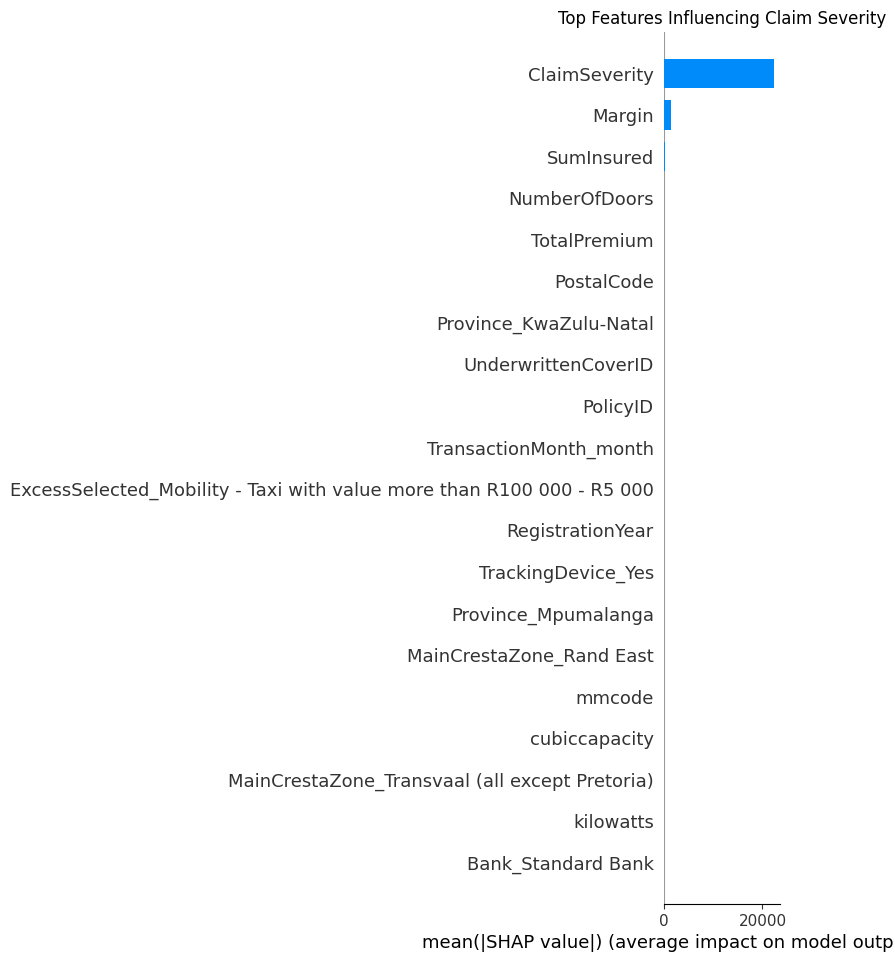

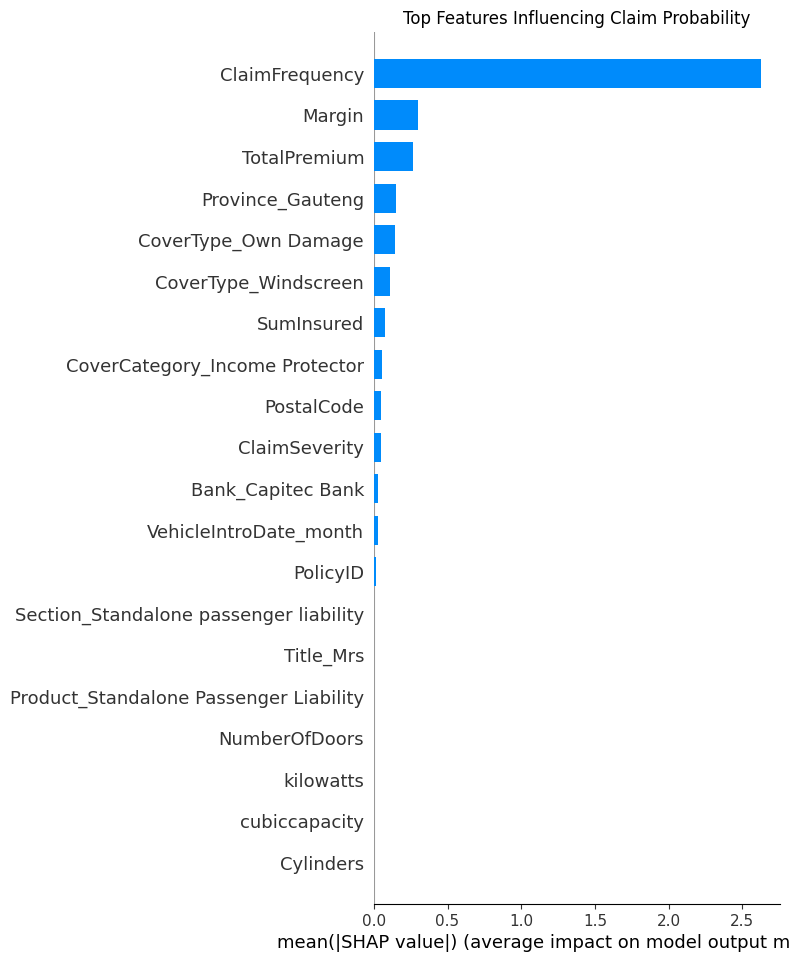

Top 10 Claim Severity Features:
ClaimSeverity             22424.289062
Margin                     1532.464233
SumInsured                  218.772766
NumberOfDoors                59.184536
TotalPremium                 49.612701
PostalCode                   44.342419
Province_KwaZulu-Natal       36.948139
UnderwrittenCoverID          34.951035
PolicyID                     29.684704
TransactionMonth_month       22.926380
dtype: float32

Top 10 Claim Probability Features:
ClaimFrequency                    2.624602
Margin                            0.301096
TotalPremium                      0.263847
Province_Gauteng                  0.153181
CoverType_Own Damage              0.140236
CoverType_Windscreen              0.106362
SumInsured                        0.077898
CoverCategory_Income Protector    0.058626
PostalCode                        0.048495
ClaimSeverity                     0.045613
dtype: float32


In [25]:
import shap

# For Claim Severity (XGBoost Regressor)
explainer_sev = shap.TreeExplainer(xgb_sev)
shap_values_sev = explainer_sev.shap_values(X_sev_train)

# Top features for severity prediction
shap.summary_plot(shap_values_sev, X_sev_train, plot_type="bar", show=False)
plt.title("Top Features Influencing Claim Severity")
plt.show()

# For Claim Probability (XGBoost Classifier)
explainer_prob = shap.TreeExplainer(xgb_prob)
shap_values_prob = explainer_prob.shap_values(X_prob_sample)  # Use sampled data

# Top features for claim probability
shap.summary_plot(shap_values_prob, X_prob_sample, plot_type="bar", show=False)
plt.title("Top Features Influencing Claim Probability")
plt.show()

# Get top 10 features for both models
top_sev_features = pd.Series(np.abs(shap_values_sev).mean(0), 
                            index=X_sev_train.columns).nlargest(10)
top_prob_features = pd.Series(np.abs(shap_values_prob).mean(0), 
                             index=X_prob_sample.columns).nlargest(10)

print("Top 10 Claim Severity Features:")
print(top_sev_features)
print("\nTop 10 Claim Probability Features:")
print(top_prob_features)


### Risk-Based Premium Calculation

In [27]:
import numpy as np

# Find common indices between test sets
common_indices = X_prob_test.index.intersection(X_sev_test.index)

# Sample 100 policies from common indices
sample_size = 100
sample_indices = np.random.choice(common_indices, size=sample_size, replace=False)

# Select samples
test_sample = X_prob_test.loc[sample_indices]
sev_sample = X_sev_test.loc[sample_indices]

# Predict probabilities and severities
prob_predictions = xgb_prob.predict_proba(test_sample)[:, 1]
severity_predictions = xgb_sev.predict(sev_sample)

# Business parameters
expense_loading = 500
profit_margin = 0.15

# Calculate premiums
premiums = (prob_predictions * severity_predictions) / (1 - profit_margin) + expense_loading

# Create results dataframe
results = pd.DataFrame({
    'Predicted_Probability': prob_predictions,
    'Predicted_Severity': severity_predictions,
    'Calculated_Premium': premiums
})

print("Example Premium Calculations:")
print(results.head(10))

print(f"\nAverage Risk-Based Premium: R{results.Calculated_Premium.mean():.2f}")
print(f"Minimum Premium: R{results.Calculated_Premium.min():.2f}")
print(f"Maximum Premium: R{results.Calculated_Premium.max():.2f}")


Example Premium Calculations:
   Predicted_Probability  Predicted_Severity  Calculated_Premium
0               0.954739         3111.868652         3995.318604
1               0.906277         3411.189697         4137.038086
2               0.960962         2091.875244         2864.956787
3               0.723086        39874.300781        34420.667969
4               0.926662         1750.906860         2408.822998
5               0.982297       103338.562500       119922.500000
6               0.949956         1166.360352         1803.519409
7               0.997103         1732.123657         2531.889648
8               0.997103        21148.853516        25308.931641
9               0.959875         2534.204102         3361.786133

Average Risk-Based Premium: R26322.42
Minimum Premium: R1326.22
Maximum Premium: R283389.75


In [28]:
results.to_csv('../data/processed/task_4_risk_based_premiums.csv', index=False)
# Save the models for future use